## _Resolving Dependencies for Colab_

In [2]:
# Install libraries for visualization when running outside Conda
import sys

COLAB = "google.colab" in sys.modules
if COLAB:
    !apt install -y swig xorg-dev libpq-dev libsdl2-dev
    !pip install -q -U swig tf-agents-nightly pyvirtualdisplay gym[atari] matplotlib

In [3]:
"""
----Setting up the Video Setting to work in colab----

rc stands for runtime environment.
"""
from matplotlib import rc
rc('animation', html='jshtml')
rc('axes', labelsize=14)


## _Imports_

In [4]:
import gymnasium as gym
import matplotlib.pyplot as plt
import matplotlib.animation as ani
import numpy as np
from time import sleep
import os

## Creating a class for Q_learning

In [56]:

class Q_learning():

  def __init__(self, LR, discount, num_episodes, range_velocity, epsilon, ep_decay, st_decay, en_decay):

    # Initializing the arguements
    self.LR= LR; self.discount= discount; self.num_episodes= num_episodes
    self.vrange= range_velocity; self.epsilon= epsilon; self.ep_decay= ep_decay
    self.start_decay= st_decay; self.end_decay= en_decay

    # Initializing the environment
    self.env= gym.make('CartPole-v1', render_mode='rgb_array')

    # Defining the changed observation
    self.LOW= self.env.observation_space.low
    self.LOW[1]= -range_velocity; self.LOW[3]= -range_velocity
    self.HIGH= self.env.observation_space.high
    self.HIGH[1]= range_velocity; self.LOW[3]= range_velocity

    self.SIZE_Q= np.array( ( [20] * len( self.HIGH ) ) )
    self.obs_range = ( self.HIGH - self.LOW ) / self.SIZE_Q

    # Initializing the Q-table
    self.Q_tb= np.random.uniform( low= -1, high=0, size= np.append( self.SIZE_Q, self.env.action_space.n ) )

    # Initializing the Reward_list for training
    self.reward_train= []; self.reward_test= []
    self.result_train= []; self.result_test= []

    # Initializing the frames for the Imageio module
    self.frames_test= {}; self.test_steps= {}; self.test_data= {}

  def Limit(self, value, cmp):

    if(value>cmp):
      return cmp
    elif(value<0-cmp):
      return 0-cmp
    else:
      return value

  def Discretize(self, obs: np.array, limiting):

    obs[3]= self.Limit( obs[3]/ 10e15, 50000 )
    obs[1]= self.Limit( obs[1]/10e15, 50000 )

    discrete= obs/limiting
    return tuple( discrete.astype(np.int32) )


  def training(self):

    for ep in range( self.num_episodes ):

      obs_temp, info_temp= self.env.reset();
      state_ini= self.Discretize(obs_temp, self.obs_range)

      term= False; trun= False
      reward_ep= 0
      temp_epsilon= self.epsilon

      while(  not (term or trun)):

        # Using epsilong-greedy policy
        if( np.random.random() < temp_epsilon ):
          action= np.random.randint(0, self.env.action_space.n)
        else:
          action= np.argmax( self.Q_tb[state_ini] )

        new_state, reward, term, trun, info_= self.env.step( action )
        discrete_state= self.Discretize( new_state, self.obs_range )

        # Updating Q-table
        next_value= np.max( self.Q_tb[discrete_state] )
        self.Q_tb[ discrete_state + (action, ) ] = (1- self.LR ) * self.Q_tb[ discrete_state + (action, ) ]
        self.Q_tb[ discrete_state + (action, ) ] = self.Q_tb[ discrete_state + (action, ) ] + self.LR*(reward + self.discount * next_value )

        state_ini= discrete_state
        reward_ep += reward

      self.reward_train.append( reward_ep )

      # print(f"Episode number: {ep + 1}, Steps: {reward_ep}, Epsilon value: {temp_epsilon}", end="\n" )
      ep_result= {'Episode number': ep + 1, 'Steps': reward_ep, 'Epsilon value': temp_epsilon}
      if(ep%10==0):
        self.result_train.append( ep_result )


      if( ep <= self.end_decay ) and (ep >= self.start_decay) and (temp_epsilon - self.ep_decay > 0):
        temp_epsilon -= self.ep_decay
      else:
        self.epsilon= 0

  def test(self, interations):

    for i in range(interations):

      obs, info_= self.env.reset()
      discrete_state= self.Discretize(obs, self.obs_range)
      trun= False; term= False

      self.frames_test[i]= []
      for step in range(400):

        self.frames_test[i].append( self.env.render() )

        # Getting the action and showing the new states
        action= np.argmax( self.Q_tb[ discrete_state ] );
        new_state, reward, term, trun, info_= self.env.step( action )

        if term or trun:
          print(f"The Agent took {step} steps before terminating.")
          self.test_steps[i]= step
          self.test_data[i]= f"The Agent took {step} steps before terminating."
          self.result_test.append( {'number': i, 'Steps':step} )

          break

        discrete_state= self.Discretize( new_state, self.obs_range )


  def stats_train(self):

    # Print out results
    print("Training results are as follows: ",end="\n\n")
    print(f"Number of episodes: { len( self.reward_train ) }")
    print(f"Max steps per episode: { np.max(self.reward_train  ) }")
    print(f"Avg steps per episode: { np.mean(self.reward_train ) }")
    print(f"Min steps per episode: { np.min(self.reward_train  ) }",end="\n\n")


## Initializing and training the agent

In [52]:
# Defining the Parameters and Initialising the Q-table
Learning_rate= 0.001
Discount= 0.98
Total_episodes= 30000
range_v= 50000

# Defining epsilon
Epsilon = 1
start_decay = 1
end_decay = Total_episodes / 3
Eps_decay_value = Epsilon / (end_decay - start_decay)


# Initializing the Agent and training the agent with
Agent= Q_learning(Learning_rate, Discount, Total_episodes, range_v, Epsilon, Eps_decay_value, start_decay, end_decay)
Agent.training()
Agent.stats_train()

# Uncomment below line to print the respective episodes numbers and their stats
Agent.stats_train()


/home/udayb/Documents/work/hub/project/Cartpole-game-using-RL/pyvenv/lib64/python3.12/site-packages/gymnasium/utils/passive_env_checker.py:159: UserWarning: WARN: The obs returned by the `reset()` method is not within the observation space.
  logger.warn(f"{pre} is not within the observation space.")
/home/udayb/Documents/work/hub/project/Cartpole-game-using-RL/pyvenv/lib64/python3.12/site-packages/gymnasium/utils/passive_env_checker.py:159: UserWarning: WARN: The obs returned by the `step()` method is not within the observation space.
  logger.warn(f"{pre} is not within the observation space.")


Training results are as follows: 

Number of episodes: 30000
Max steps per episode: 40.0
Avg steps per episode: 9.465766666666667
Min steps per episode: 8.0

Training results are as follows: 

Number of episodes: 30000
Max steps per episode: 40.0
Avg steps per episode: 9.465766666666667
Min steps per episode: 8.0



## Testing the agent

In [53]:
Agent.test( interations= 10 )

The Agent took 8 steps before terminating.
The Agent took 8 steps before terminating.
The Agent took 7 steps before terminating.
The Agent took 7 steps before terminating.
The Agent took 8 steps before terminating.
The Agent took 9 steps before terminating.
The Agent took 8 steps before terminating.
The Agent took 8 steps before terminating.
The Agent took 7 steps before terminating.
The Agent took 8 steps before terminating.


## Visualising the results

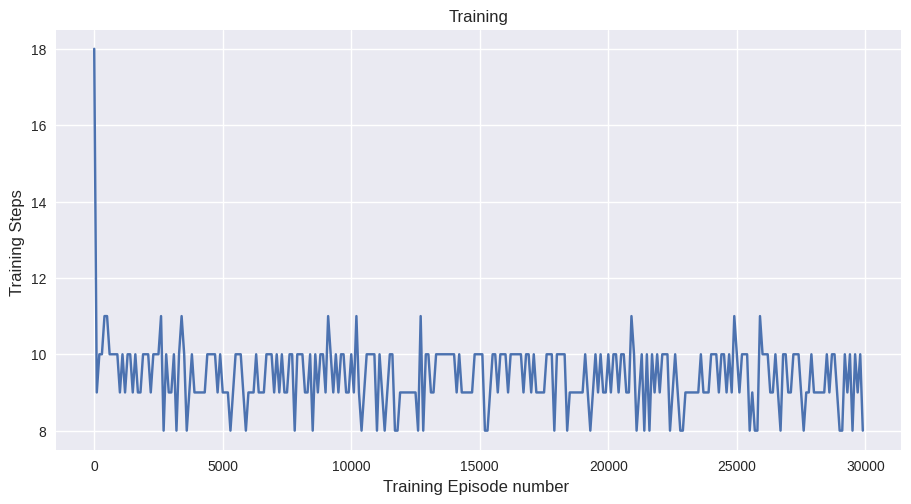

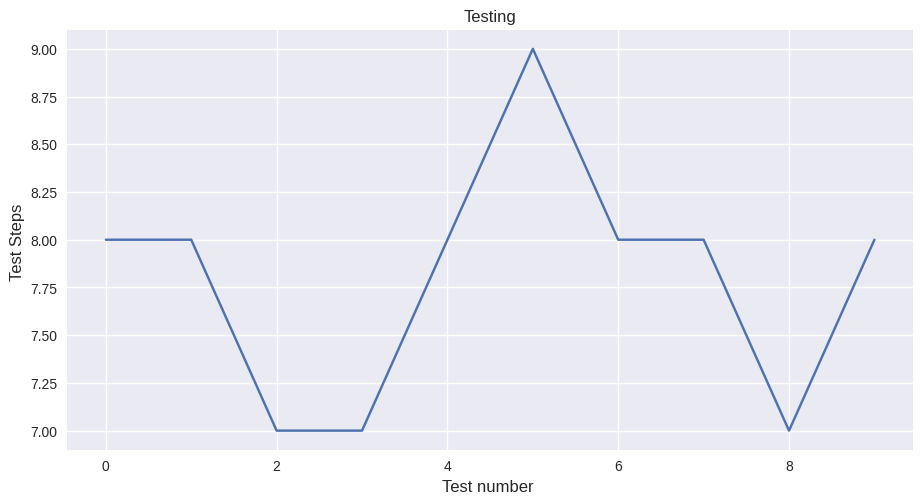

In [55]:
Train_ep= [ temp['Episode number'] for temp in Agent.result_train ]; Train_step= [ temp['Steps'] for temp in Agent.result_train ]
Test_ep= [ temp['number'] for temp in Agent.result_test ]; Test_step= [ temp['Steps'] for temp in Agent.result_test ]


plt.figure(figsize= (24, 12))
plt.subplot(2,2,1)
plt.title('Training')
plt.xlabel("Training Episode number ", fontsize=12, loc='center')
plt.ylabel("Training Steps ", fontsize=12, loc='center')
plt.style.use(style="seaborn-v0_8")

plt.plot( Train_ep, Train_step )


plt.figure(figsize= (24, 12))
plt.subplot(2,2,1)
plt.title('Testing')
plt.xlabel("Test number ", fontsize=12, loc='center')
plt.ylabel("Test Steps ", fontsize=12, loc='center')
plt.style.use(style="seaborn-v0_8")

plt.plot( Test_ep, Test_step )

## _Displaying the CartPole Game Animation_

In [ ]:
# Create functions to update scene and display animation
def NEXT(n, Frame, Patch):

    Patch.set_data( Frame[n] )
    return Patch

# Selecting the frame for which we are showing the animation
index= 9
Frames= Agent.frames_test[index]
def plt_animation( frames ):

    # Setting the figure for the display
    fig = plt.figure()

    # Showing the image with the help of imshow method of the pyplot module
    Patch = plt.imshow(frames[0])
    anim = ani.FuncAnimation( fig, NEXT, fargs=(frames, Patch), frames=len(frames), repeat=False, interval=20)
    plt.close()

    return anim

plt_animation( Frames )